# Desafio Economapas – Engenheiro de Dados Jr

# Descrição do desafio

Desafio Economapas – Engenheiro de Dados Jr (Prazo de entrega sugerido: 5 dias)

Parabéns, você foi selecionado para etapa do Desafio!

Ele consiste em uma questão que deverá ser desenvolvida, conforme as instruções a seguir.

Boa sorte!

As tabelas fornecidas, no arquivo anexo, contêm dados relativos à prospecção de potenciais clientes (leads), e aqueles que foram efetivamente convertidos, tornando-se clientes (vendidos).

A partir desses dados, qual recomendação você daria ao setor de marketing, visando maximizar a taxa de conversão de leads em clientes, considerando as características que possuem as melhores chances de conversão, em futuras campanhas/investimentos? Como foi possível chegar a essa conclusão?

A análise poderá ser apresentada de forma livre, por textos, gráficos, tabelas ou apresentações, de acordo com o que você julgar necessário para entendimento dos resultados.

# Jupyter notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

# Configs
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)
random.seed(seed)
# https://mljar.com/blog/feature-importance-in-random-forest/
# !pip install openpyxl

In [2]:
df = pd.read_csv('df_join.csv')
df.head(1)

,LEAD_ID,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO
0,11316042,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão


## Valores Dupicados

In [3]:
len(df)-len(df.drop_duplicates())

126

In [4]:
df = df.drop_duplicates()

## Valores nulos

Alguns dados de `SUB-ORIGEM` estão faltando

<AxesSubplot:>

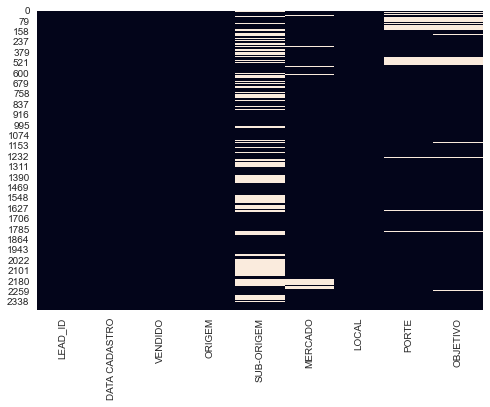

In [5]:
sns.heatmap(df.isnull(), cbar=False)

## Análise ed cada feature individual

In [6]:
def eda_categ_feat_desc_plot(series_categorical, title = "", fix_labels=False, rotate=False, fontsize=11):
    """Generate 2 plots: barplot with quantity and pieplot with percentage. 
       @series_categorical: categorical series
       @title: optional
       @fix_labels: The labes plot in barplot in sorted by values, some times its bugs cuz axis ticks is alphabethic
           if this happens, pass True in fix_labels
       @bar_format: pass {:,.0f} to int
    """
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)
    # barplot
    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    if(fix_labels):
        val_concat = val_concat.sort_values(series_name).reset_index()
    ## Insert numbers
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], '{:,d}'.format(int(row['quantity'])), color='black', ha="center")
    ## rotate
    if(rotate):
        s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')
    # pi plot
    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot", textprops={'fontsize': fontsize})

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

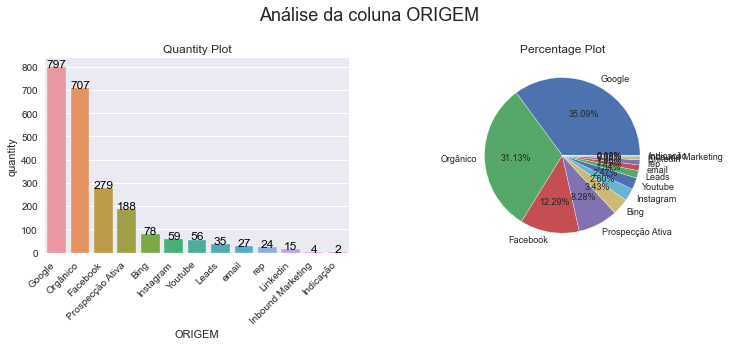

In [7]:
eda_categ_feat_desc_plot(df['ORIGEM'], title="Análise da coluna ORIGEM", rotate=True, fontsize=9)

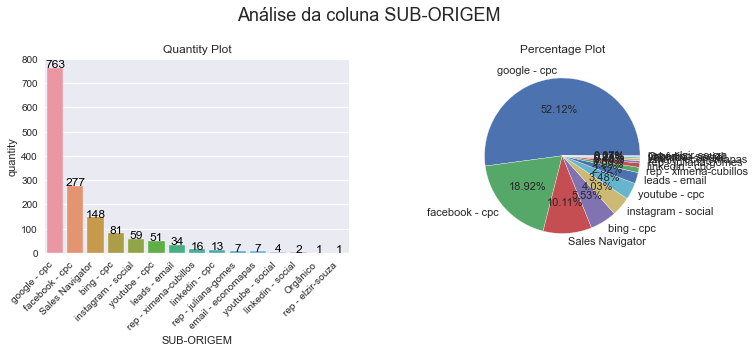

In [8]:
eda_categ_feat_desc_plot(df['SUB-ORIGEM'], title="Análise da coluna SUB-ORIGEM", rotate=True)

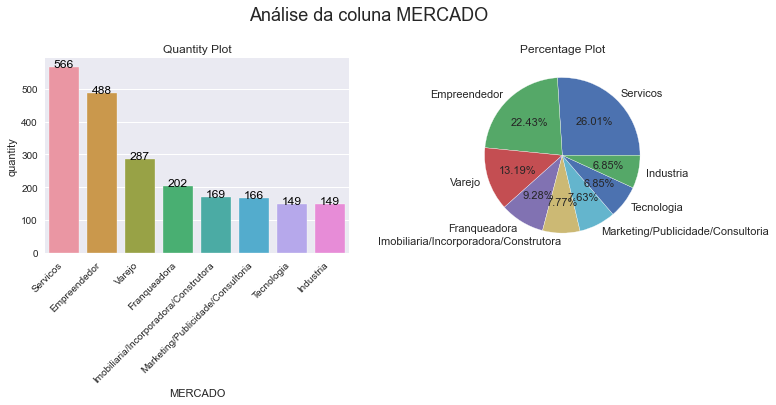

In [9]:
eda_categ_feat_desc_plot(df['MERCADO'], title="Análise da coluna MERCADO", rotate=True)

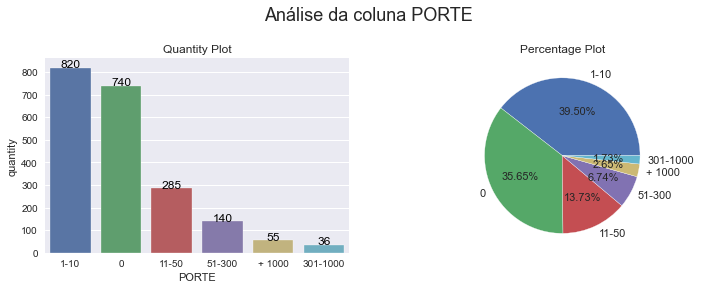

In [10]:
eda_categ_feat_desc_plot(df['PORTE'], title="Análise da coluna PORTE")

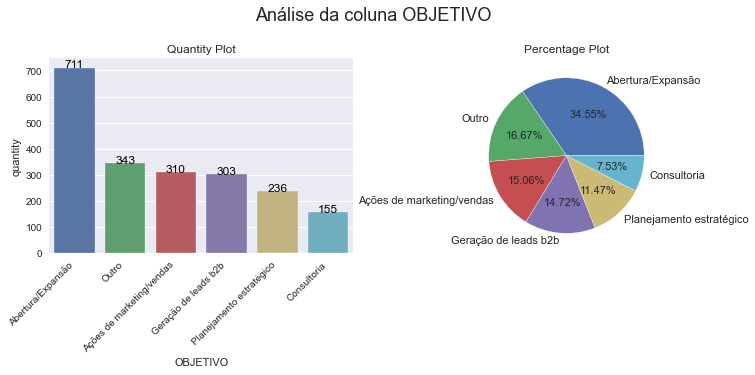

In [11]:
eda_categ_feat_desc_plot(df['OBJETIVO'], title="Análise da coluna OBJETIVO", rotate=True)

## Análise dos dados de SUCESSO

In [12]:
df_sucess =  df[ df['VENDIDO'] == 'SIM']

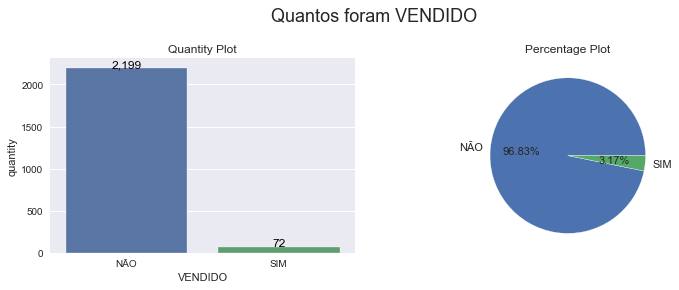

In [13]:
eda_categ_feat_desc_plot(df['VENDIDO'], title="Quantos foram VENDIDO")

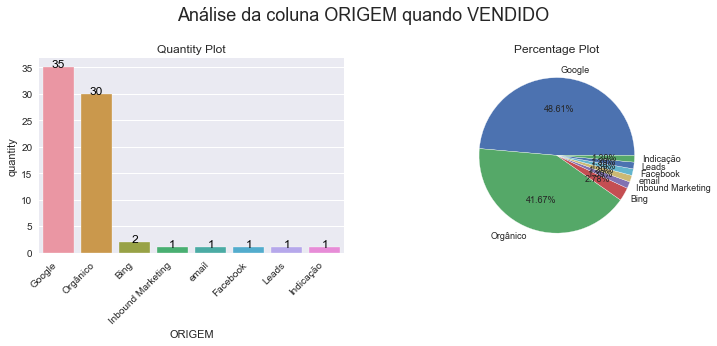

In [14]:
eda_categ_feat_desc_plot(df_sucess['ORIGEM'], title="Análise da coluna ORIGEM quando VENDIDO", rotate=True, fontsize=9)

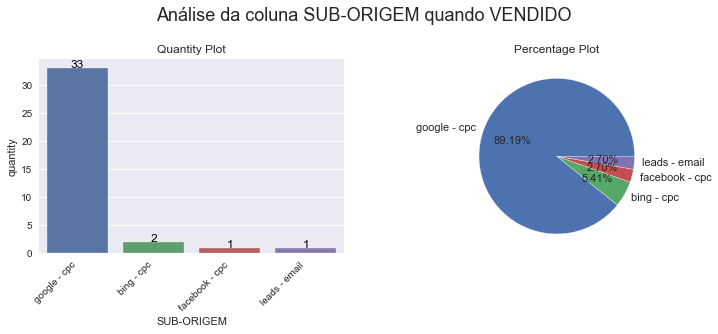

In [15]:
eda_categ_feat_desc_plot(df_sucess['SUB-ORIGEM'], title="Análise da coluna SUB-ORIGEM quando VENDIDO", rotate=True)

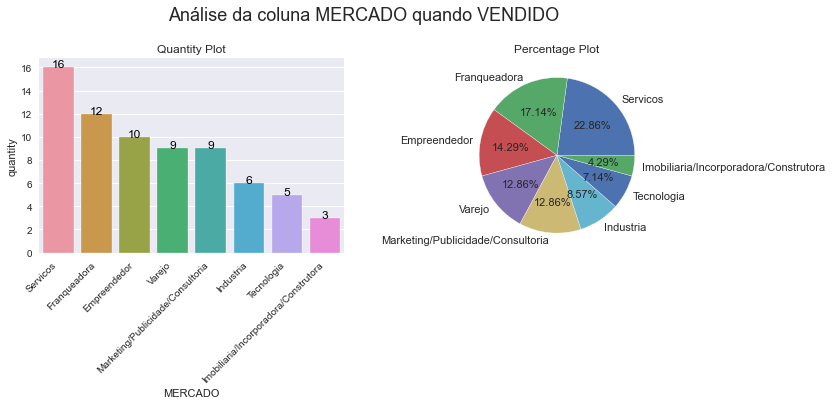

In [16]:
eda_categ_feat_desc_plot(df_sucess['MERCADO'], title="Análise da coluna MERCADO quando VENDIDO", rotate=True)

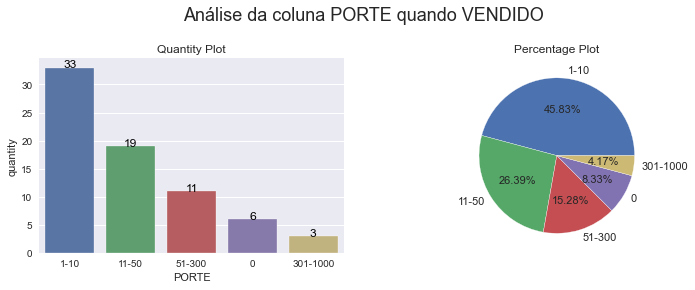

In [17]:
eda_categ_feat_desc_plot(df_sucess['PORTE'], title="Análise da coluna PORTE quando VENDIDO")

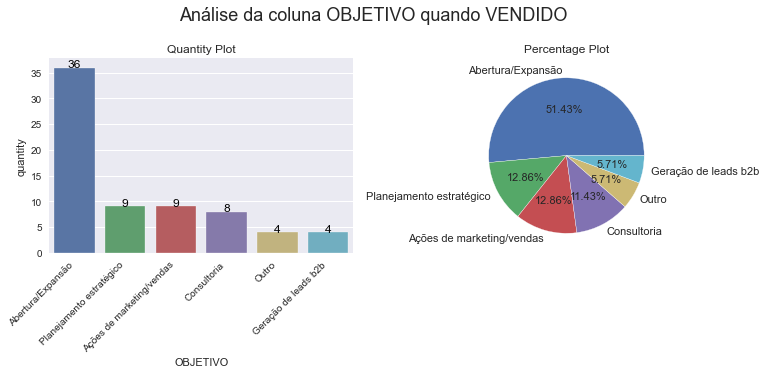

In [18]:
eda_categ_feat_desc_plot(df_sucess['OBJETIVO'], title="Análise da coluna OBJETIVO quando VENDIDO", rotate=True)

## Análise avaliando cada coluna com VENDIDO (Modo Descritivo)

In [19]:
df.head(1)

,LEAD_ID,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO
0,11316042,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão


In [20]:
def df_create_describe_cat_by_target_binary(adf, x_column, y, positive_y):
    mydf = adf[x_column].value_counts()
    mydf = pd.concat((mydf,
                      adf[x_column].value_counts(normalize=True),
                      adf[adf[y] == positive_y][x_column].value_counts()), axis=1)
    mydf = mydf.fillna(0.0)
    mydf = mydf.set_axis(['QuantidadeTotal', 'PorcentagemTotal', 'QuantidadeYES'], axis='columns')
    def divide_cols(row):
        if(row['QuantidadeYES'] == 0.0):
            return 0.0
        return row['QuantidadeYES'] / row['QuantidadeTotal']
    mydf['QuantidadeNO'] = mydf.apply(
        lambda row: row['QuantidadeTotal'] - int(row['QuantidadeYES']), axis=1)
    mydf['percentage_YES'] = mydf.apply(lambda row: divide_cols(row), axis=1)
    mydf['percentage_NO'] = mydf.apply(lambda row: 1.0 - row['percentage_YES'], axis=1)
    mydf = mydf.sort_values(by='percentage_YES', ascending=False)
    # convert types
    for c in ['QuantidadeYES','QuantidadeNO']:
        mydf[c] = mydf[c].apply(int)
    for c in ['PorcentagemTotal','percentage_YES','percentage_NO']:
        mydf[c] = mydf[c].apply(lambda x: '{:.2%}'.format(x))
    return mydf

In [21]:
df_create_describe_cat_by_target_binary(df, 'ORIGEM', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Indicação,2,0.09%,1,1,50.00%,50.00%
Inbound Marketing,4,0.18%,1,3,25.00%,75.00%
Google,797,35.09%,35,762,4.39%,95.61%
Orgânico,707,31.13%,30,677,4.24%,95.76%
email,27,1.19%,1,26,3.70%,96.30%
Leads,35,1.54%,1,34,2.86%,97.14%
Bing,78,3.43%,2,76,2.56%,97.44%
Facebook,279,12.29%,1,278,0.36%,99.64%
Prospecção Ativa,188,8.28%,0,188,0.00%,100.00%
Instagram,59,2.60%,0,59,0.00%,100.00%


In [22]:
df_create_describe_cat_by_target_binary(df, 'SUB-ORIGEM', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
google - cpc,763,52.12%,33,730,4.33%,95.67%
leads - email,34,2.32%,1,33,2.94%,97.06%
bing - cpc,81,5.53%,2,79,2.47%,97.53%
facebook - cpc,277,18.92%,1,276,0.36%,99.64%
Sales Navigator,148,10.11%,0,148,0.00%,100.00%
instagram - social,59,4.03%,0,59,0.00%,100.00%
youtube - cpc,51,3.48%,0,51,0.00%,100.00%
rep - ximena-cubillos,16,1.09%,0,16,0.00%,100.00%
linkedin - cpc,13,0.89%,0,13,0.00%,100.00%
rep - juliana-gomes,7,0.48%,0,7,0.00%,100.00%


In [23]:
df_create_describe_cat_by_target_binary(df, 'MERCADO', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Franqueadora,202,9.28%,12,190,5.94%,94.06%
Marketing/Publicidade/Consultoria,166,7.63%,9,157,5.42%,94.58%
Industria,149,6.85%,6,143,4.03%,95.97%
Tecnologia,149,6.85%,5,144,3.36%,96.64%
Varejo,287,13.19%,9,278,3.14%,96.86%
Servicos,566,26.01%,16,550,2.83%,97.17%
Empreendedor,488,22.43%,10,478,2.05%,97.95%
Imobiliaria/Incorporadora/Construtora,169,7.77%,3,166,1.78%,98.22%


In [24]:
df_create_describe_cat_by_target_binary(df, 'PORTE', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
301-1000,36,1.73%,3,33,8.33%,91.67%
51-300,140,6.74%,11,129,7.86%,92.14%
11-50,285,13.73%,19,266,6.67%,93.33%
1-10,820,39.50%,33,787,4.02%,95.98%
0,740,35.65%,6,734,0.81%,99.19%
+ 1000,55,2.65%,0,55,0.00%,100.00%


In [25]:
df_create_describe_cat_by_target_binary(df, 'OBJETIVO', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Consultoria,155,7.53%,8,147,5.16%,94.84%
Abertura/Expansão,711,34.55%,36,675,5.06%,94.94%
Planejamento estratégico,236,11.47%,9,227,3.81%,96.19%
Ações de marketing/vendas,310,15.06%,9,301,2.90%,97.10%
Geração de leads b2b,303,14.72%,4,299,1.32%,98.68%
Outro,343,16.67%,4,339,1.17%,98.83%


## Análise avaliando cada coluna com VENDIDO (Modo Visual)

In [26]:
def describe_y_classify_by_cat_feat_one_col(mydf, x, y, title='',
                                    classify_content='por VENDIDO', labels=['NÃO', 'SIM'], rotate=False):
    # Usado quando há muitos valores, impossibilitando ficar lado a lado
    """
    Generate one barplot with quantity and len(x.unique()) pie plots with percentage of x by class of y.unique()
    @classify_content : string that is the meaning of y
    @labels : start from 0, is the meanign of y value
    """
    # Create DataSet
    df1 = mydf.groupby([x,y]).count().reset_index()
    a_column = df1.columns[2]
    df1 = df1.rename({a_column: "quantity"}, axis=1)
    alist = df1['quantity'].tolist()
    unique_values_x = mydf[x].unique().tolist()
    unique_values_x = [x for x in unique_values_x if str(x) != 'nan']
    unique_values_x.sort()
    len_unique_values_y = len(mydf[y].unique().tolist())
    # Create Fig and Axes
    f, ax = plt.subplots(figsize=(14,5))
#     f, ax = plt.subplots(ncols=len(unique_values_x)+1, figsize=(18, 5), sharex=False, )
    f.suptitle(title, fontsize=18)
    
    # BarPlot
    s = sns.barplot(x=x, y='quantity', hue=y, data=df1)
    count, by_hue = 0, 0
    for index, row in df1.iterrows():
        axis_x = count - 0.20 if index % 2 == 0 else count + 0.20
        by_hue += 1
        if(by_hue == len_unique_values_y):
            count += 1
            by_hue = 0
            # print(axis_x) ## DEBUG
        s.text(axis_x, row['quantity'], '{:,d}'.format(int(row['quantity'])), color='black', ha="center")
    if(rotate):
        s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')
    # Query DF
    hue_count = 0
    for i in range(len(unique_values_x)):
        df1.query('{} == "{}"'.format(x, unique_values_x[i])).plot.pie(y='quantity', figsize=(18, 5), autopct='%1.2f%%',
                                    labels = ['{} = {}'.format(labels[0], str(alist[i+hue_count])),
                                              '{} = {}'.format(labels[1], str(alist[i+hue_count+1]))],
                                    title='{} {} {} (Total = {})'.format(x, unique_values_x[i], classify_content ,str(alist[i] + alist[i+1])),
                                     labeldistance=None)
#         hue_count += 1
    plt.show()
    # return df1 ## DEBUG
    
# describe_y_classify_by_cat_feat_one_col(df, x='embarked', y='survived', title='survived by sex')

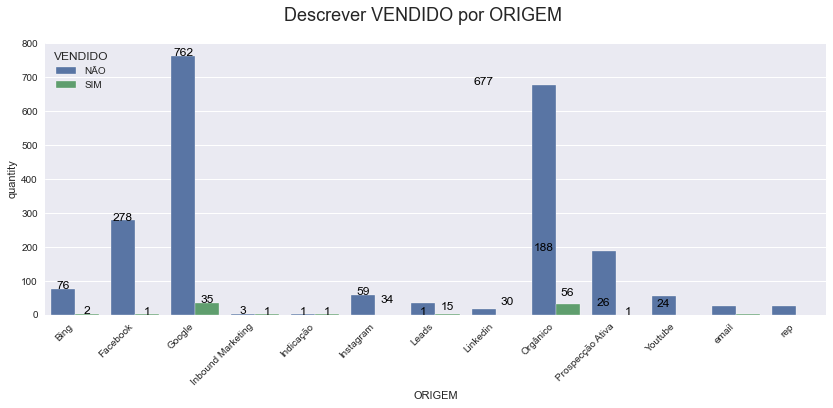

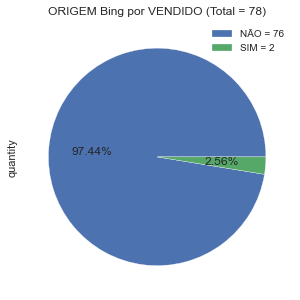

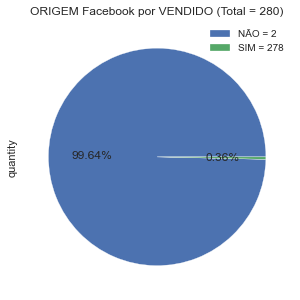

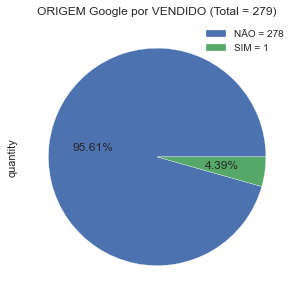

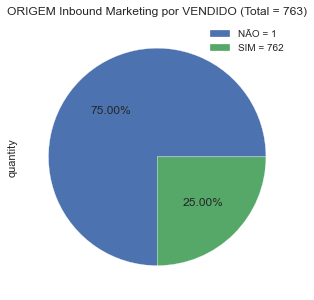

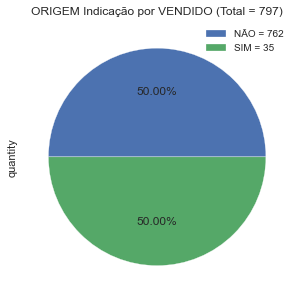

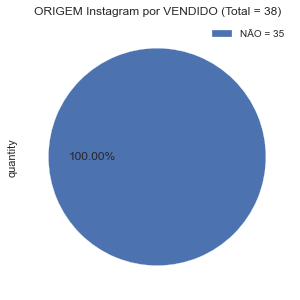

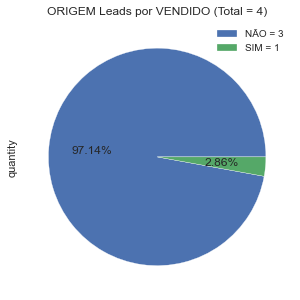

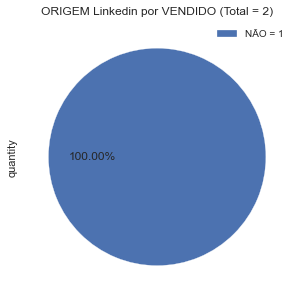

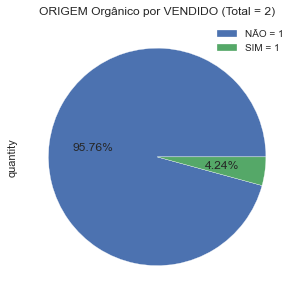

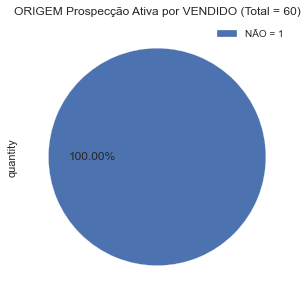

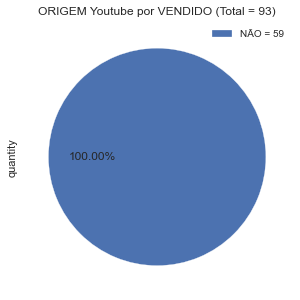

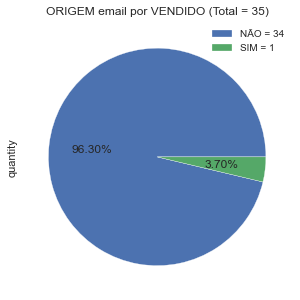

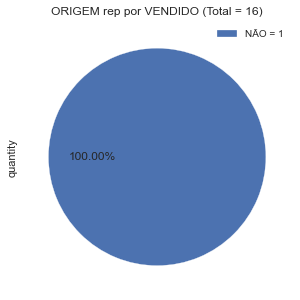

In [27]:
describe_y_classify_by_cat_feat_one_col(df, x='ORIGEM', y='VENDIDO', title='Descrever VENDIDO por ORIGEM', rotate=True )

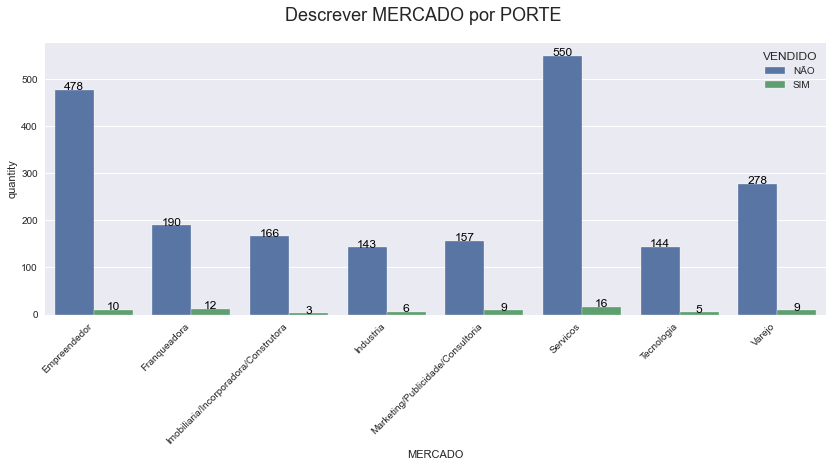

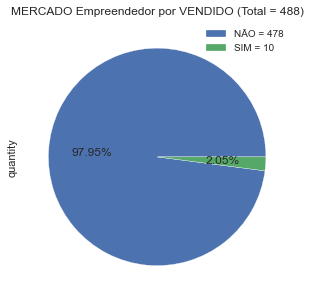

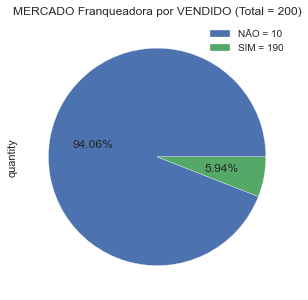

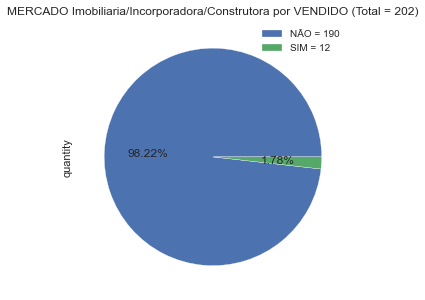

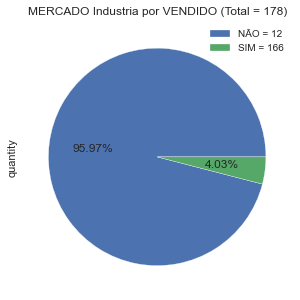

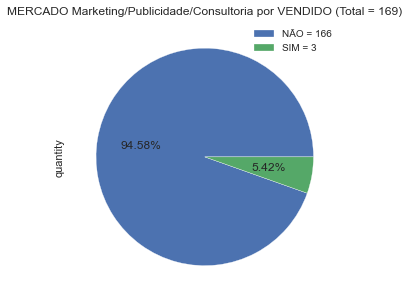

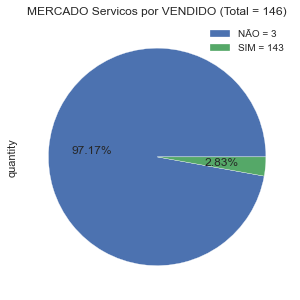

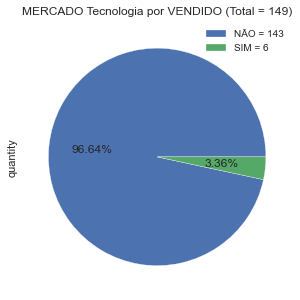

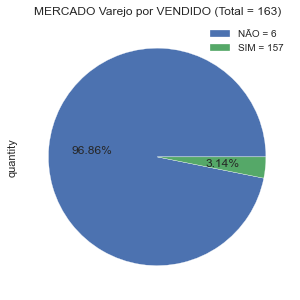

In [28]:
describe_y_classify_by_cat_feat_one_col(df, x='MERCADO', y='VENDIDO', title='Descrever MERCADO por PORTE', rotate=True )

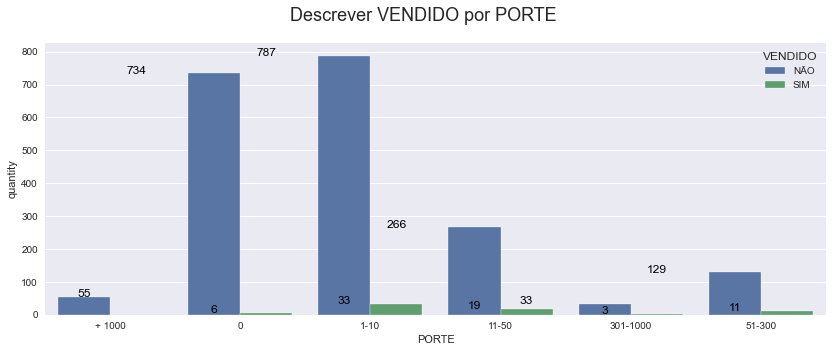

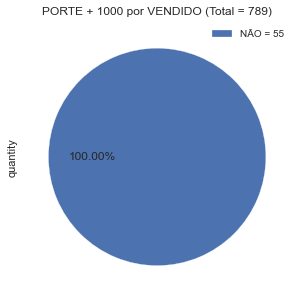

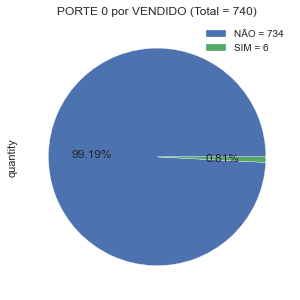

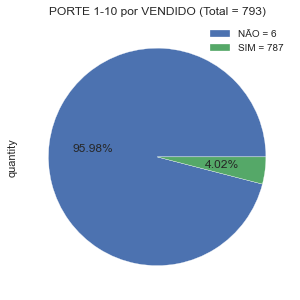

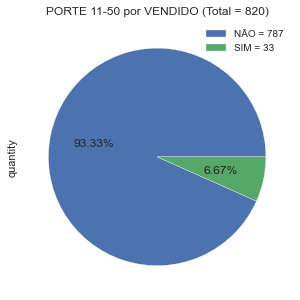

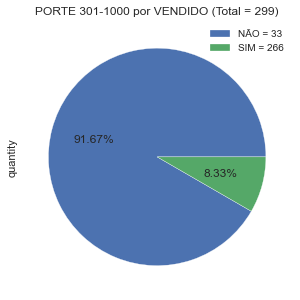

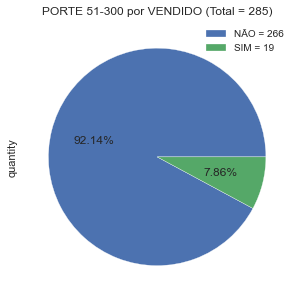

In [29]:
describe_y_classify_by_cat_feat_one_col(df, x='PORTE', y='VENDIDO', title='Descrever VENDIDO por PORTE' )

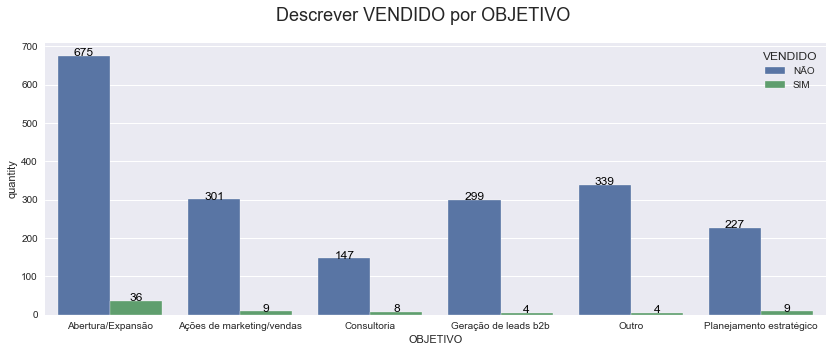

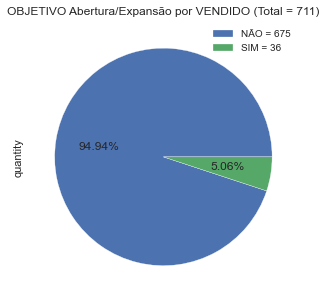

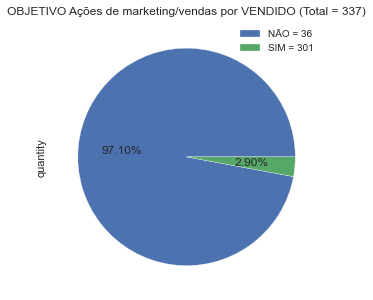

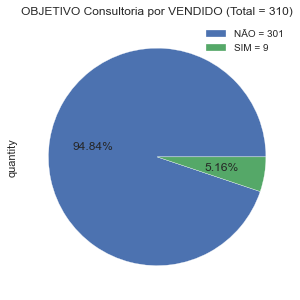

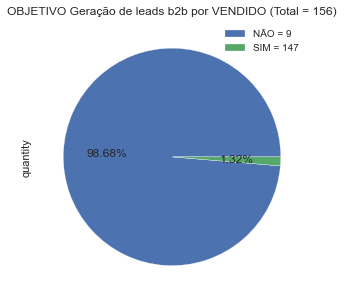

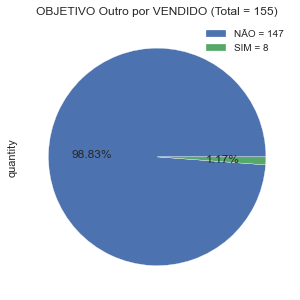

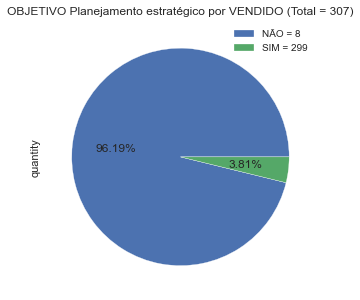

In [30]:
describe_y_classify_by_cat_feat_one_col(df, x='OBJETIVO', y='VENDIDO', title='Descrever VENDIDO por OBJETIVO' )

## Estados

In [31]:
def generate_states(row):
    mapping_problem_cities = {
        'São João del-Rei - MG': 'MG',
        'Tome-Acu - PA': 'PA',
        'Belo Horizonte, Minas Gerais': 'MG',
        'Paraná, Brasil': 'PR',
        'Cheyenne, WY': 'SEM ESTADO'
        
    }
    if(row['LOCAL'] in mapping_problem_cities.keys()):
        return mapping_problem_cities[row['LOCAL']]
    if(row['LOCAL'] == '-'):
        return 'SEM ESTADO'
    elif(row['LOCAL'] == 'Minas Gerais'):
        return 'MG'
    elif(row['LOCAL'] == 'São Paulo'):
        return 'SP'
    elif(row['LOCAL'] == 'Rio de Janeiro'):
        return 'RJ'
    elif(row['LOCAL'] == 'RS'):
        return 'RS'
    elif(row['LOCAL'] == 'RJ'):
        return 'RJ'
    elif(row['LOCAL'] == 'Pr'):
        return 'PR'
    elif(row['LOCAL'] == 'Sergipe'):
        return 'SE'
    elif(row['LOCAL'].find(',') != -1):
        return row['LOCAL'].split(',')[1].strip()
    else:
        return row['LOCAL'].split('-')[1].strip()

In [32]:
df['ESTADO'] = df.apply(lambda row: generate_states(row), axis=1)

In [33]:
df_create_describe_cat_by_target_binary(df, 'ESTADO', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
PI,16,0.70%,1,15,6.25%,93.75%
SP,605,26.64%,36,569,5.95%,94.05%
DF,68,2.99%,3,65,4.41%,95.59%
ES,24,1.06%,1,23,4.17%,95.83%
PE,54,2.38%,2,52,3.70%,96.30%
RJ,249,10.96%,9,240,3.61%,96.39%
MA,32,1.41%,1,31,3.12%,96.88%
MT,32,1.41%,1,31,3.12%,96.88%
MG,192,8.45%,6,186,3.12%,96.88%
CE,70,3.08%,2,68,2.86%,97.14%


In [34]:
def generate_cities(row):
    mapping_problem_cities = {
        '-': 'SEM CIDADE',
        'São Paulo': 'São Paulo',
        'Rio de Janeiro': 'Rio de Janeiro',
        'São João del-Rei - MG': 'São João del-Rei',
        'Tome-Acu - PA': 'Tome-Acu',
        'Belo Horizonte, Minas Gerais': 'Belo Horizonte',
        'Paraná, Brasil': 'SEM CIDADE',
        'Cheyenne, WY': 'SEM CIDADE'
    }
    if(row['LOCAL'] in mapping_problem_cities.keys()):
        return mapping_problem_cities[row['LOCAL']]
    elif(row['LOCAL'].find(',') != -1):
        return row['LOCAL'].split(',')[0].strip()
    else:
        return row['LOCAL'].split('-')[0].strip()

In [35]:
df['CIDADE'] = df.apply(lambda row: generate_cities(row), axis=1)

In [36]:
df_city = df_create_describe_cat_by_target_binary(df, 'CIDADE', 'VENDIDO', 'SIM')
df_city[:30]

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
RS,1,0.04%,1,0,100.00%,0.00%
Apucarana,1,0.04%,1,0,100.00%,0.00%
Mococa,1,0.04%,1,0,100.00%,0.00%
Descalvado,1,0.04%,1,0,100.00%,0.00%
Guararema,1,0.04%,1,0,100.00%,0.00%
Iomere,1,0.04%,1,0,100.00%,0.00%
Eusébio,1,0.04%,1,0,100.00%,0.00%
Nova Lima,1,0.04%,1,0,100.00%,0.00%
Ilhabela,2,0.09%,1,1,50.00%,50.00%
RJ,2,0.09%,1,1,50.00%,50.00%


In [37]:
df_city.sort_values(by='QuantidadeTotal',ascending=False)

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
São Paulo,297,13.08%,19,278,6.40%,93.60%
SEM CIDADE,263,11.58%,5,258,1.90%,98.10%
Rio de Janeiro,139,6.12%,2,137,1.44%,98.56%
Brasília,68,2.99%,3,65,4.41%,95.59%
Belo Horizonte,59,2.60%,2,57,3.39%,96.61%
...,...,...,...,...,...,...
Igarape Miri,1,0.04%,0,1,0.00%,100.00%
Torres,1,0.04%,0,1,0.00%,100.00%
Lucas do Rio Verde,1,0.04%,0,1,0.00%,100.00%
Itapecerica da Serra,1,0.04%,0,1,0.00%,100.00%


# Tomada de decisão

Agrupando analises

## Origem

+ **Focar**:
 - Continuar na ORIGEM 'Indicação', 'Inbound Marketing' mesmo tendo poucas ocorrencias pois tiveram altas taxas de retorno 50%
  - Continuar focando em 'Google', 'Orgânico', que são os que mais traz trouxeram lead
 
+ **Reduzir**
      - Reduzir facebook, tem 0.36% enquanto que google e organico cerca de 4.20% 11 vezes menor ue 'Google', 'Orgânico' e é ot receiro que mais tem ocorrencias
  - De preferencia parar de usar 'Prospecção Ativa', 'Instagram', 'Youtube', 'rep', 'Linkedin' pois nnão obtiverma nenhum resultado

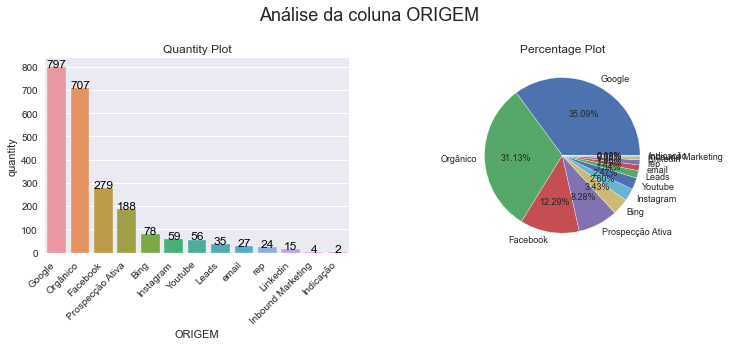

In [38]:
eda_categ_feat_desc_plot(df['ORIGEM'], title="Análise da coluna ORIGEM", rotate=True, fontsize=9)

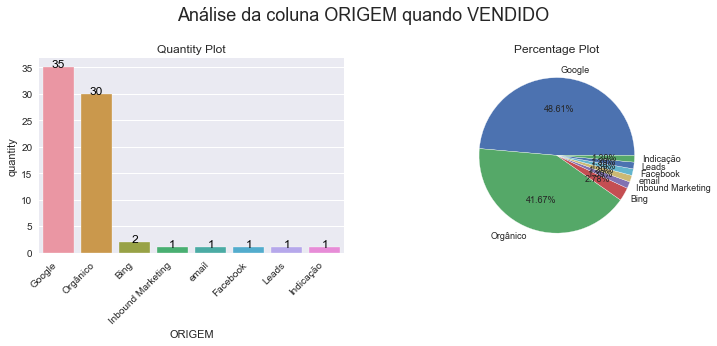

In [39]:
eda_categ_feat_desc_plot(df_sucess['ORIGEM'], title="Análise da coluna ORIGEM quando VENDIDO", rotate=True, fontsize=9)

In [40]:
df_create_describe_cat_by_target_binary(df, 'ORIGEM', 'VENDIDO', 'SIM').index

Index(['Indicação', 'Inbound Marketing', 'Google', 'Orgânico', 'email',
       'Leads', 'Bing', 'Facebook', 'Prospecção Ativa', 'Instagram', 'Youtube',
       'rep', 'Linkedin'],
      dtype='object')

In [41]:
df_create_describe_cat_by_target_binary(df, 'ORIGEM', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Indicação,2,0.09%,1,1,50.00%,50.00%
Inbound Marketing,4,0.18%,1,3,25.00%,75.00%
Google,797,35.09%,35,762,4.39%,95.61%
Orgânico,707,31.13%,30,677,4.24%,95.76%
email,27,1.19%,1,26,3.70%,96.30%
Leads,35,1.54%,1,34,2.86%,97.14%
Bing,78,3.43%,2,76,2.56%,97.44%
Facebook,279,12.29%,1,278,0.36%,99.64%
Prospecção Ativa,188,8.28%,0,188,0.00%,100.00%
Instagram,59,2.60%,0,59,0.00%,100.00%


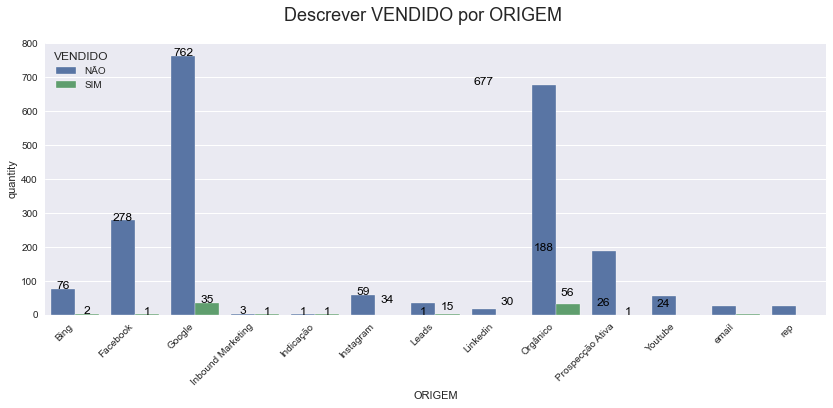

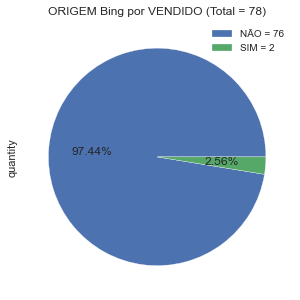

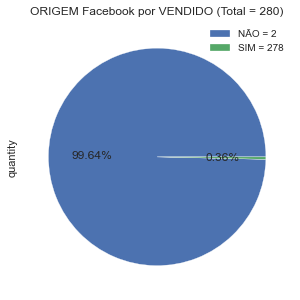

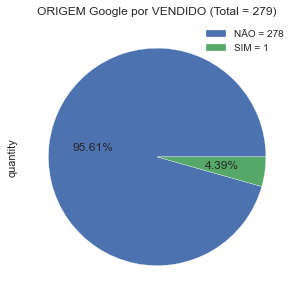

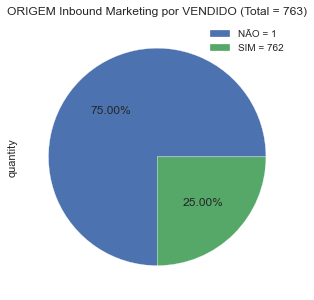

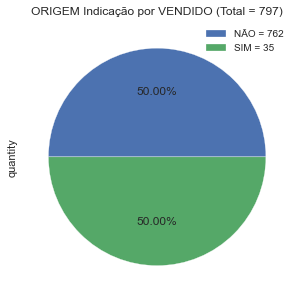

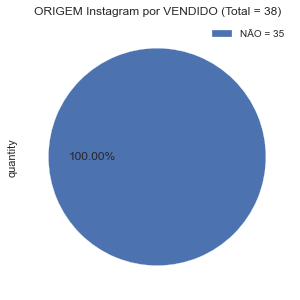

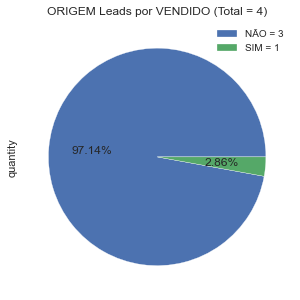

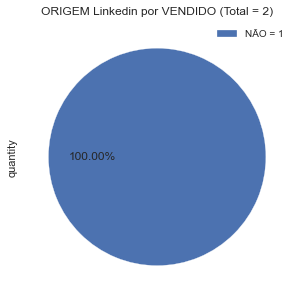

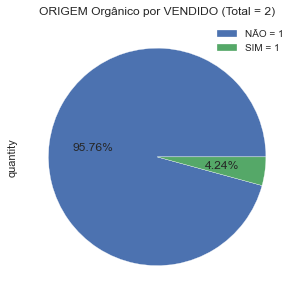

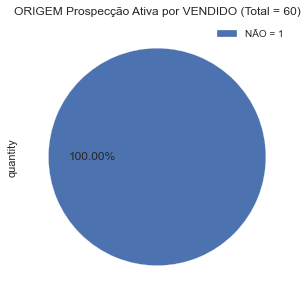

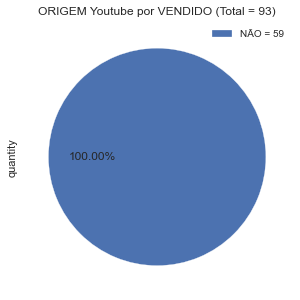

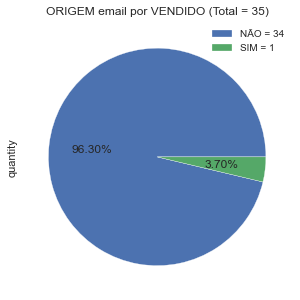

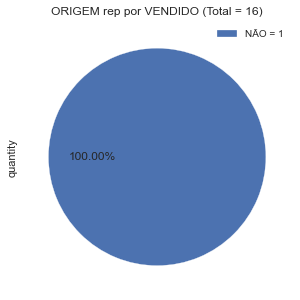

In [42]:
describe_y_classify_by_cat_feat_one_col(df, x='ORIGEM', y='VENDIDO', title='Descrever VENDIDO por ORIGEM', rotate=True )

## SUB-ORIGEM

Semelhante ao caso de origem, o facebbok tem uma taxa muito menor que o restattne.

Mesmo que o google seja cerca de 50% ele representa 90% do retorno, com uma taxa umpouco maior que os outros, leads - email	 e bing - cpc	

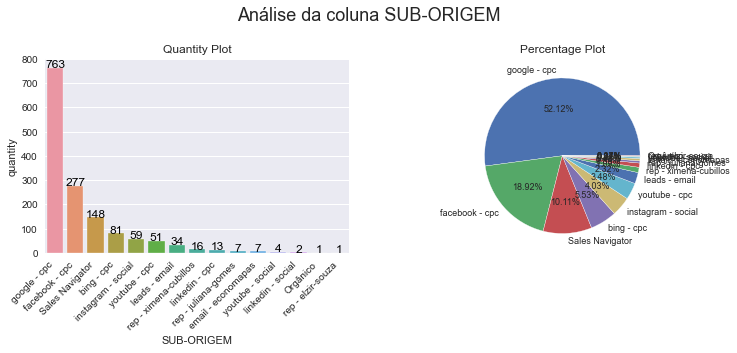

In [43]:
eda_categ_feat_desc_plot(df['SUB-ORIGEM'], title="Análise da coluna SUB-ORIGEM", rotate=True, fontsize=9)

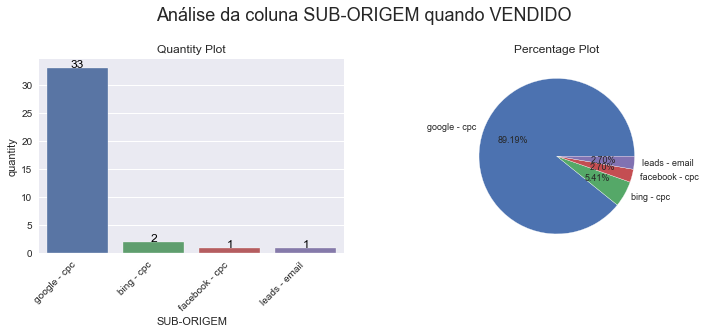

In [44]:
eda_categ_feat_desc_plot(df_sucess['SUB-ORIGEM'], title="Análise da coluna SUB-ORIGEM quando VENDIDO", rotate=True, fontsize=9)

In [45]:
df_create_describe_cat_by_target_binary(df, 'SUB-ORIGEM', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
google - cpc,763,52.12%,33,730,4.33%,95.67%
leads - email,34,2.32%,1,33,2.94%,97.06%
bing - cpc,81,5.53%,2,79,2.47%,97.53%
facebook - cpc,277,18.92%,1,276,0.36%,99.64%
Sales Navigator,148,10.11%,0,148,0.00%,100.00%
instagram - social,59,4.03%,0,59,0.00%,100.00%
youtube - cpc,51,3.48%,0,51,0.00%,100.00%
rep - ximena-cubillos,16,1.09%,0,16,0.00%,100.00%
linkedin - cpc,13,0.89%,0,13,0.00%,100.00%
rep - juliana-gomes,7,0.48%,0,7,0.00%,100.00%


## MERCADO

Franqueadora', 'Marketing/Publicidade/Consultoria' fazem o dobro do que tem mais ocorrencias 'Servicos', 'Empreendedor' mesmo estes sendo quase 50% enquanto que os outros dois junto 15$ de todos as ocrrencias. Entâo deveria focar nelse ao invez desses

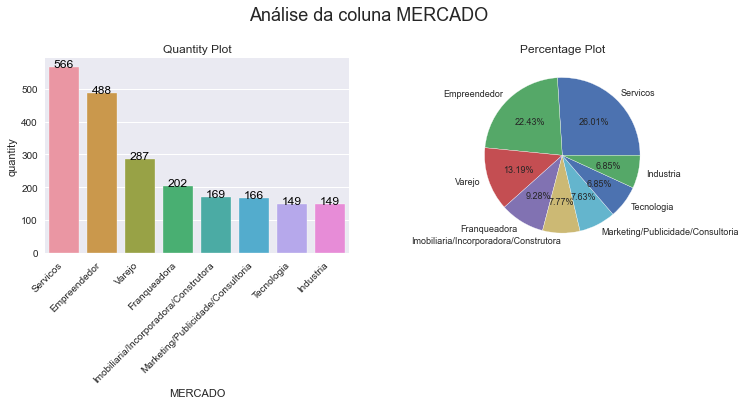

In [46]:
eda_categ_feat_desc_plot(df['MERCADO'], title="Análise da coluna MERCADO", rotate=True, fontsize=9)

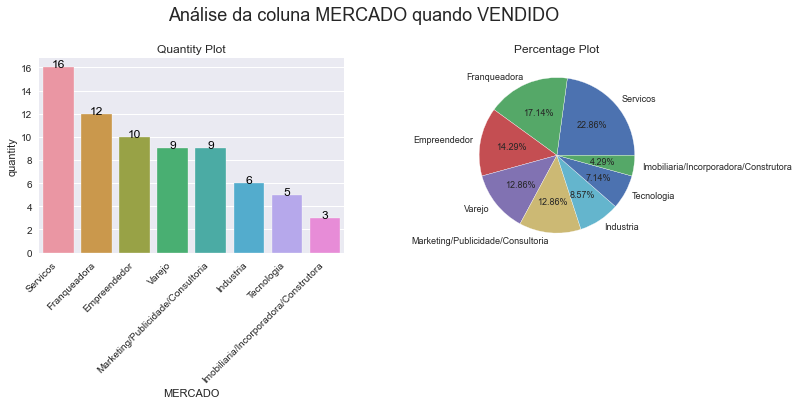

In [47]:
eda_categ_feat_desc_plot(df_sucess['MERCADO'], title="Análise da coluna MERCADO quando VENDIDO", rotate=True, fontsize=9)

In [48]:
df_create_describe_cat_by_target_binary(df, 'MERCADO', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Franqueadora,202,9.28%,12,190,5.94%,94.06%
Marketing/Publicidade/Consultoria,166,7.63%,9,157,5.42%,94.58%
Industria,149,6.85%,6,143,4.03%,95.97%
Tecnologia,149,6.85%,5,144,3.36%,96.64%
Varejo,287,13.19%,9,278,3.14%,96.86%
Servicos,566,26.01%,16,550,2.83%,97.17%
Empreendedor,488,22.43%,10,478,2.05%,97.95%
Imobiliaria/Incorporadora/Construtora,169,7.77%,3,166,1.78%,98.22%


In [49]:
df_create_describe_cat_by_target_binary(df, 'MERCADO', 'VENDIDO', 'SIM').index

Index(['Franqueadora', 'Marketing/Publicidade/Consultoria', 'Industria',
       'Tecnologia', 'Varejo', 'Servicos', 'Empreendedor',
       'Imobiliaria/Incorporadora/Construtora'],
      dtype='object')

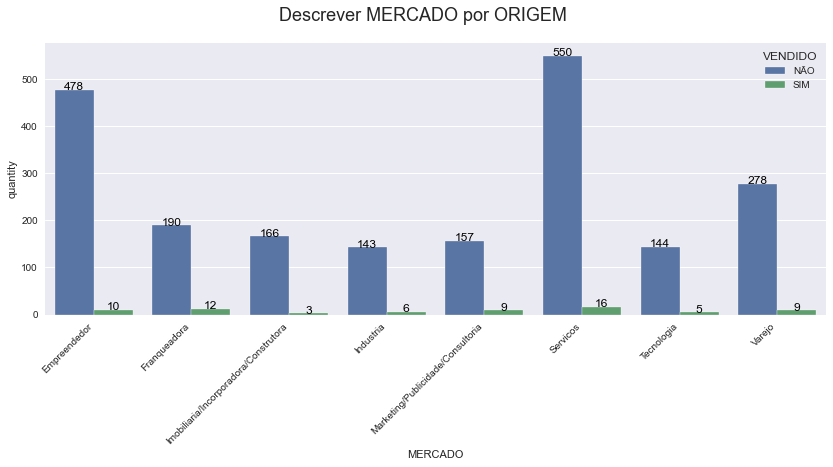

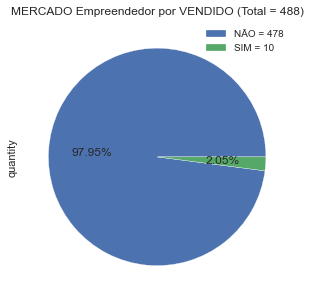

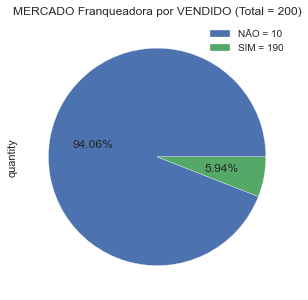

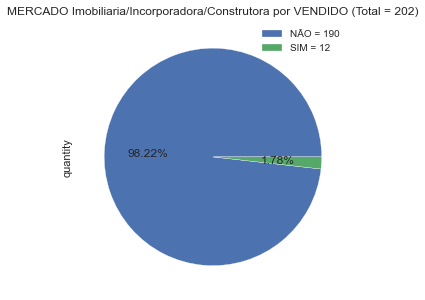

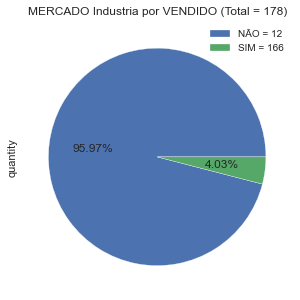

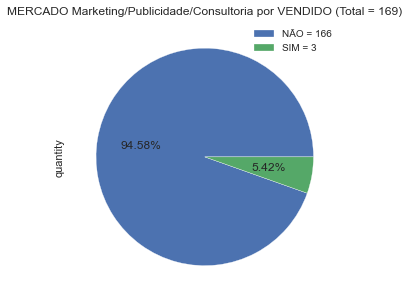

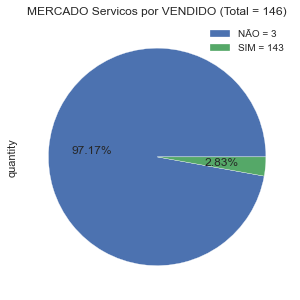

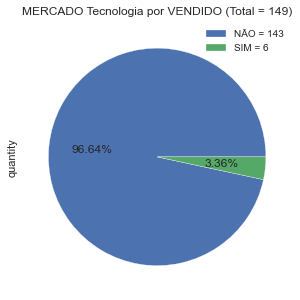

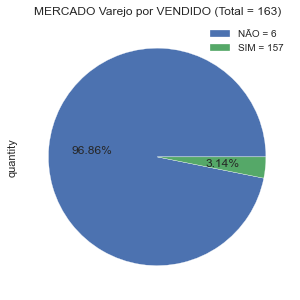

In [50]:
describe_y_classify_by_cat_feat_one_col(df, x='MERCADO', y='VENDIDO', title='Descrever MERCADO por ORIGEM', rotate=True )

## PORTE

A medida que aumenta o porte, maior é a taxa de se obeter Lead (para > 100 nao houve nenhuma ocorrencia.

A sugestao seria buscar sempre quem tem protes maiores, e buscar mais registros para ter certeza disso

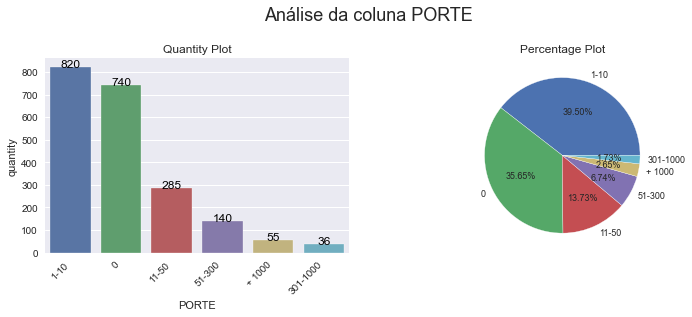

In [51]:
eda_categ_feat_desc_plot(df['PORTE'], title="Análise da coluna PORTE", rotate=True, fontsize=9)

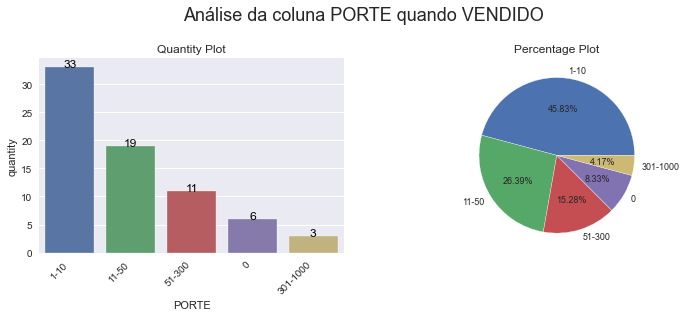

In [52]:
eda_categ_feat_desc_plot(df_sucess['PORTE'], title="Análise da coluna PORTE quando VENDIDO", rotate=True, fontsize=9)

In [53]:
df_create_describe_cat_by_target_binary(df, 'PORTE', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
301-1000,36,1.73%,3,33,8.33%,91.67%
51-300,140,6.74%,11,129,7.86%,92.14%
11-50,285,13.73%,19,266,6.67%,93.33%
1-10,820,39.50%,33,787,4.02%,95.98%
0,740,35.65%,6,734,0.81%,99.19%
+ 1000,55,2.65%,0,55,0.00%,100.00%


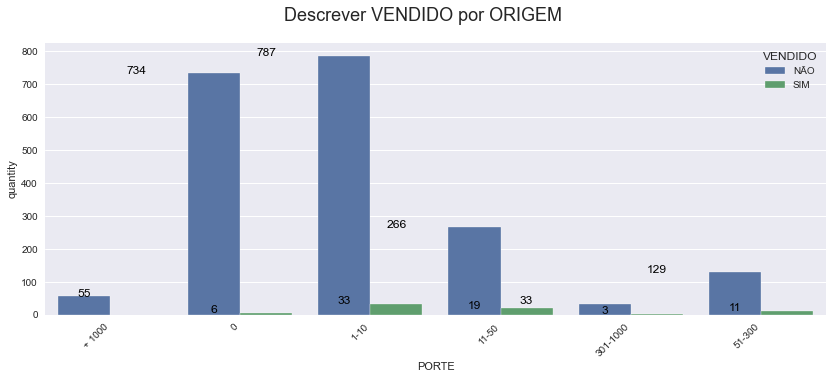

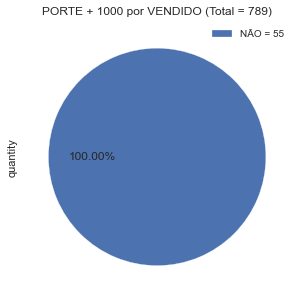

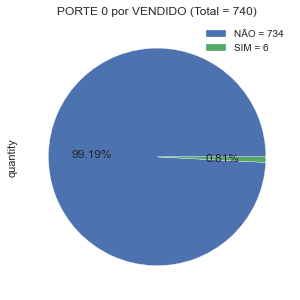

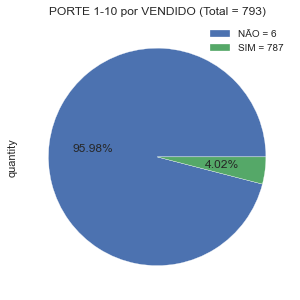

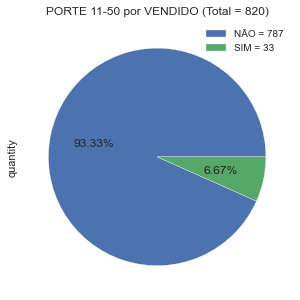

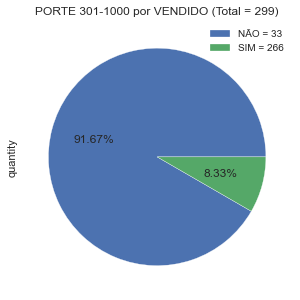

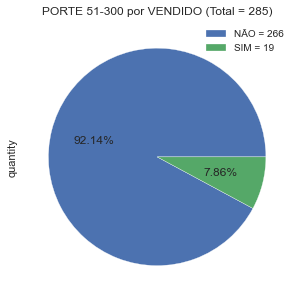

In [54]:
describe_y_classify_by_cat_feat_one_col(df, x='PORTE', y='VENDIDO', title='Descrever VENDIDO por ORIGEM', rotate=True )

## OBJETIVO

Reduzir 'Geração de leads b2b', 'Outro' e focar mais em 'Consultoria', 'Abertura/Expansão' que tem uma taxa muito maior

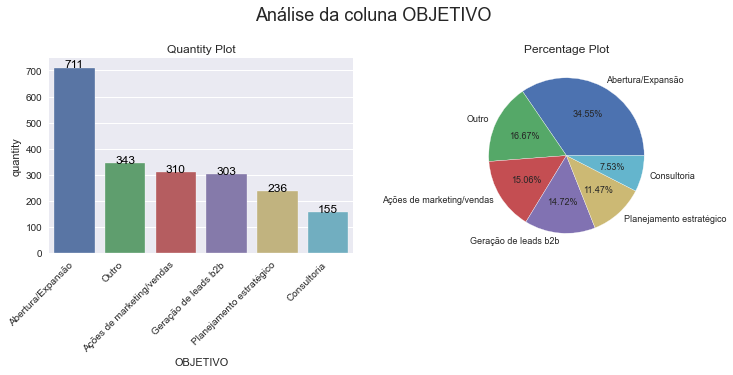

In [55]:
eda_categ_feat_desc_plot(df['OBJETIVO'], title="Análise da coluna OBJETIVO", rotate=True, fontsize=9)

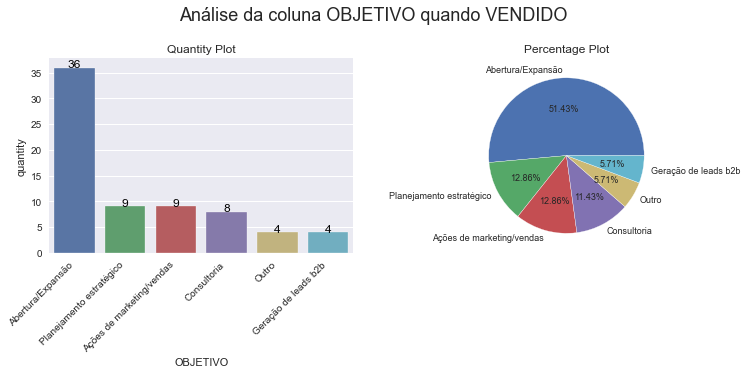

In [56]:
eda_categ_feat_desc_plot(df_sucess['OBJETIVO'], title="Análise da coluna OBJETIVO quando VENDIDO", rotate=True, fontsize=9)

In [57]:
df_create_describe_cat_by_target_binary(df, 'OBJETIVO', 'VENDIDO', 'SIM').index

Index(['Consultoria', 'Abertura/Expansão', 'Planejamento estratégico',
       'Ações de marketing/vendas', 'Geração de leads b2b', 'Outro'],
      dtype='object')

In [58]:
df_create_describe_cat_by_target_binary(df, 'OBJETIVO', 'VENDIDO', 'SIM')

,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Consultoria,155,7.53%,8,147,5.16%,94.84%
Abertura/Expansão,711,34.55%,36,675,5.06%,94.94%
Planejamento estratégico,236,11.47%,9,227,3.81%,96.19%
Ações de marketing/vendas,310,15.06%,9,301,2.90%,97.10%
Geração de leads b2b,303,14.72%,4,299,1.32%,98.68%
Outro,343,16.67%,4,339,1.17%,98.83%


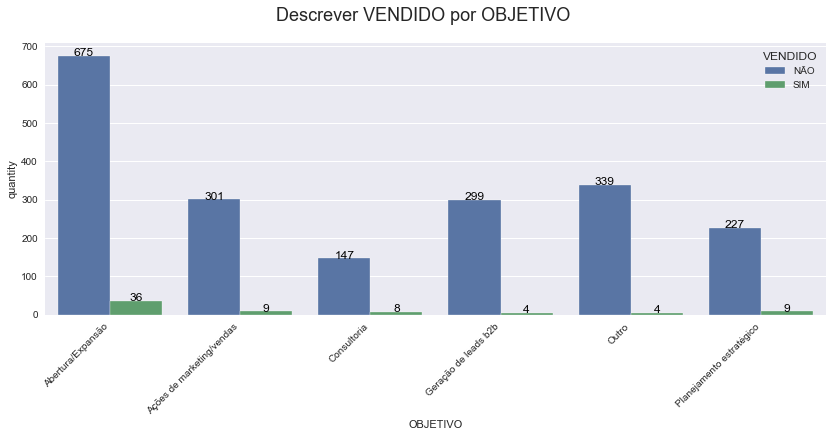

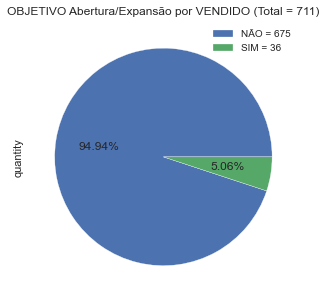

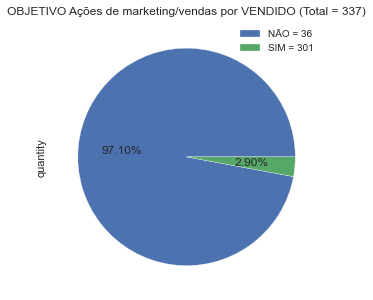

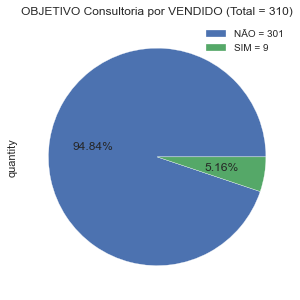

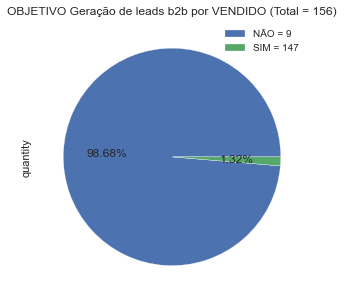

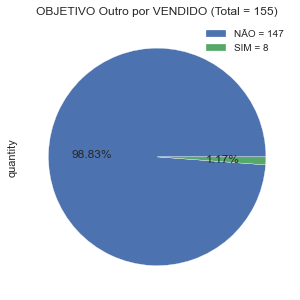

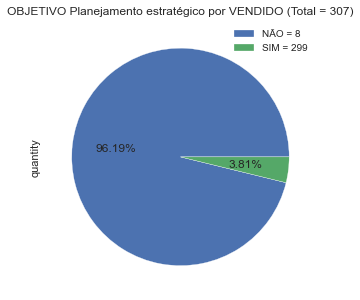

In [59]:
describe_y_classify_by_cat_feat_one_col(df, x='OBJETIVO', y='VENDIDO', title='Descrever VENDIDO por OBJETIVO', rotate=True )

## END

In [60]:
df.columns

Index(['LEAD_ID', 'DATA CADASTRO', 'VENDIDO', 'ORIGEM', 'SUB-ORIGEM',
       'MERCADO', 'LOCAL', 'PORTE', 'OBJETIVO', 'ESTADO', 'CIDADE'],
      dtype='object')

In [62]:
feat_columns = ['ORIGEM', 'SUB-ORIGEM', 'MERCADO', 'LOCAL', 'PORTE', 'OBJETIVO', 'ESTADO', 'CIDADE']

In [74]:
def dfs_describe_y_by_many_feats_by_cat_feats(adf, feat_cols, y, positive_y, title=''):
    """
    @feat_cols = Lista de features categoricas a serem avaliadas
    O meso que df_create_describe_cat_by_target_binary, mas permite analisar maiis rapidamente
    para outros df. Assim permite que alem de describe Y, voce possa descrever Y por outras features
    Como fazer a analisa pcom uma coluna constante como por df[ df['Y'] == constant_value]
    """
    if(title):
        print(title, '\n')
    for x_col in feat_cols:
        print('==> ', x_col)
        display(df_create_describe_cat_by_target_binary(adf, x_col, y, positive_y))
        print('\n\n')
# dfs_describe_y_by_many_feats_by_cat_feats(
#     df[ df['PORTE'] == '51-300'], feat_columns,
#     'VENDIDO', 'SIM', title='Prop para PORTE-51-300 ')

In [67]:
df.head()

,LEAD_ID,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO,ESTADO,CIDADE
0,11316042,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão,PA,Belém
1,11374979,2021-02-17 11:10:28,NÃO,Orgânico,NaN,Varejo,"São Paulo, SP",11-50,NaN,SP,São Paulo
2,11997870,2021-04-15 11:06:00,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,SEM ESTADO,SEM CIDADE
3,11930537,2021-04-09 13:10:21,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,SEM ESTADO,SEM CIDADE
4,11899381,2021-04-07 13:13:49,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,SEM ESTADO,SEM CIDADE


In [70]:
sub_df = df[ df['PORTE'] == '51-300']
sub_df

,LEAD_ID,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO,ESTADO,CIDADE
28,10566142,2020-12-01 05:46:39,NÃO,Google,google - cpc,NaN,Cariacica - ES,51-300,Abertura/Expansão,ES,Cariacica
30,10581011,2020-12-01 18:02:28,NÃO,Google,google - cpc,NaN,Missal - PR,51-300,Planejamento estratégico,PR,Missal
145,11259578,2021-02-05 12:06:20,NÃO,Google,google - cpc,Servicos,Colatina - ES,51-300,Ações de marketing/vendas,ES,Colatina
170,11234339,2021-02-03 10:46:07,NÃO,Google,google - cpc,Tecnologia,Santo André - SP,51-300,Geração de leads b2b,SP,Santo André
173,11375164,2021-02-17 11:26:22,NÃO,Google,google - cpc,Marketing/Publicidade/Consultoria,Sorocaba - SP,51-300,Planejamento estratégico,SP,Sorocaba
...,...,...,...,...,...,...,...,...,...,...,...
2314,10922736,2021-01-10 13:02:14,NÃO,Orgânico,NaN,Varejo,Ribeirão Preto - SP,51-300,Outro,SP,Ribeirão Preto
2350,11002797,2021-01-15 15:52:33,NÃO,Google,google - cpc,Varejo,Itajaí - SC,51-300,Abertura/Expansão,SC,Itajaí
2371,11371137,2021-02-16 23:21:17,NÃO,Facebook,facebook - cpc,Varejo,Feira de Santana - BA,51-300,Ações de marketing/vendas,BA,Feira de Santana
2377,12002261,2021-04-15 14:42:07,NÃO,Google,google - cpc,Varejo,São Paulo - SP,51-300,Ações de marketing/vendas,SP,São Paulo


In [73]:
dfs_describe_y_by_many_feats_by_cat_feats(df[ df['PORTE'] == '51-300'], feat_columns, 'VENDIDO', 'SIM', title='Prop para PORTE-51-300 ')

Prop para PORTE-51-300  

==>  ORIGEM


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Google,65,46.43%,7,58,10.77%,89.23%
Orgânico,55,39.29%,4,51,7.27%,92.73%
Facebook,9,6.43%,0,9,0.00%,100.00%
email,5,3.57%,0,5,0.00%,100.00%
Bing,3,2.14%,0,3,0.00%,100.00%
Linkedin,2,1.43%,0,2,0.00%,100.00%
rep,1,0.71%,0,1,0.00%,100.00%





==>  SUB-ORIGEM


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
google - cpc,59,77.63%,7,52,11.86%,88.14%
facebook - cpc,9,11.84%,0,9,0.00%,100.00%
bing - cpc,3,3.95%,0,3,0.00%,100.00%
linkedin - cpc,2,2.63%,0,2,0.00%,100.00%
email - economapas,2,2.63%,0,2,0.00%,100.00%
rep - ximena-cubillos,1,1.32%,0,1,0.00%,100.00%





==>  MERCADO


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Marketing/Publicidade/Consultoria,8,5.97%,2,6,25.00%,75.00%
Franqueadora,14,10.45%,2,12,14.29%,85.71%
Industria,16,11.94%,2,14,12.50%,87.50%
Varejo,15,11.19%,1,14,6.67%,93.33%
Servicos,36,26.87%,2,34,5.56%,94.44%
Tecnologia,24,17.91%,1,23,4.17%,95.83%
Imobiliaria/Incorporadora/Construtora,16,11.94%,0,16,0.00%,100.00%
Empreendedor,5,3.73%,0,5,0.00%,100.00%





==>  LOCAL


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Iomere - SC,1,0.71%,1,0,100.00%,0.00%
Coronel Fabriciano - MG,1,0.71%,1,0,100.00%,0.00%
Ilhabela - SP,1,0.71%,1,0,100.00%,0.00%
Osasco - SP,1,0.71%,1,0,100.00%,0.00%
Recife - PE,2,1.43%,1,1,50.00%,50.00%
...,...,...,...,...,...,...
Aparecida de Goiania - GO,1,0.71%,0,1,0.00%,100.00%
Araguaína - TO,1,0.71%,0,1,0.00%,100.00%
Imbiribeira - PE,1,0.71%,0,1,0.00%,100.00%
Rio de Janeiro - RJ,14,10.00%,0,14,0.00%,100.00%





==>  PORTE


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
51-300,140,100.00%,11,129,7.86%,92.14%





==>  OBJETIVO


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Ações de marketing/vendas,18,13.04%,2,16,11.11%,88.89%
Abertura/Expansão,41,29.71%,4,37,9.76%,90.24%
Consultoria,11,7.97%,1,10,9.09%,90.91%
Planejamento estratégico,24,17.39%,2,22,8.33%,91.67%
Geração de leads b2b,29,21.01%,2,27,6.90%,93.10%
Outro,15,10.87%,0,15,0.00%,100.00%





==>  ESTADO


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
MT,2,1.43%,1,1,50.00%,50.00%
PE,3,2.14%,1,2,33.33%,66.67%
SP,43,30.71%,6,37,13.95%,86.05%
MG,16,11.43%,2,14,12.50%,87.50%
SC,10,7.14%,1,9,10.00%,90.00%
AL,2,1.43%,0,2,0.00%,100.00%
RO,1,0.71%,0,1,0.00%,100.00%
TO,1,0.71%,0,1,0.00%,100.00%
GO,1,0.71%,0,1,0.00%,100.00%
MS,1,0.71%,0,1,0.00%,100.00%





==>  CIDADE


,QuantidadeTotal,PorcentagemTotal,QuantidadeYES,QuantidadeNO,percentage_YES,percentage_NO
Iomere,1,0.71%,1,0,100.00%,0.00%
Osasco,1,0.71%,1,0,100.00%,0.00%
Ilhabela,1,0.71%,1,0,100.00%,0.00%
Coronel Fabriciano,1,0.71%,1,0,100.00%,0.00%
Recife,2,1.43%,1,1,50.00%,50.00%
...,...,...,...,...,...,...
Imbiribeira,1,0.71%,0,1,0.00%,100.00%
Porto Velho,1,0.71%,0,1,0.00%,100.00%
Penapolis,1,0.71%,0,1,0.00%,100.00%
Rio de Janeiro,16,11.43%,0,16,0.00%,100.00%
